In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
data = pd.read_csv("clean_Tweets.csv")

X = data["text"]
y = data["airline_sentiment"]

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
# tf-idf vectorization
max_features = 5000  # Number of TF-IDF features
vectorizer = TfidfVectorizer(max_features=max_features, token_pattern=r"(?u)\b\w+\b")
X_vectorized = vectorizer.fit_transform(X).toarray()  # Convert to dense array for Keras

In [ ]:
# balance the dataset
sampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = sampler.fit_resample(X_vectorized, y)

In [ ]:
# reshaping the tf-idf for GRU
seq_length = 50
X_reshaped = X_resampled.reshape(-1, max_features // seq_length, seq_length)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_resampled, test_size=0.2, random_state=42)

In [ ]:
model = Sequential([
    Dense(128, activation="relu", input_shape=(max_features // seq_length, seq_length)),
    GRU(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax")
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.3888 - loss: 1.0762 - val_accuracy: 0.5363 - val_loss: 0.8853
Epoch 2/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.5291 - loss: 0.9119 - val_accuracy: 0.5529 - val_loss: 0.8782
Epoch 3/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5673 - loss: 0.8619 - val_accuracy: 0.6496 - val_loss: 0.7636
Epoch 4/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6435 - loss: 0.7726 - val_accuracy: 0.6814 - val_loss: 0.7301
Epoch 5/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6667 - loss: 0.7526 - val_accuracy: 0.6933 - val_loss: 0.7176
Epoch 6/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.6740 - loss: 0.7348 - val_accuracy: 0.6832 - val_loss: 0.7175
Epoch 7/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6761 - loss: 0.7216 - val_accuracy: 0.6869 - val_loss: 0.7168
Epoch 8/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6880 - loss: 0.7061 - val_accurac

In [ ]:
# Evaluate model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.75      0.87      0.80      1903
     neutral       0.71      0.60      0.65      1761
    positive       0.75      0.74      0.75      1784

    accuracy                           0.74      5448
   macro avg       0.74      0.74      0.73      5448
weighted avg       0.74      0.74      0.73      5448



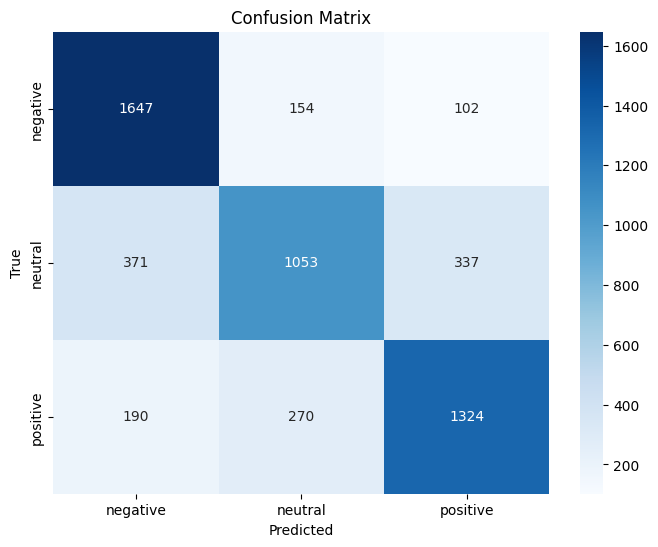

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

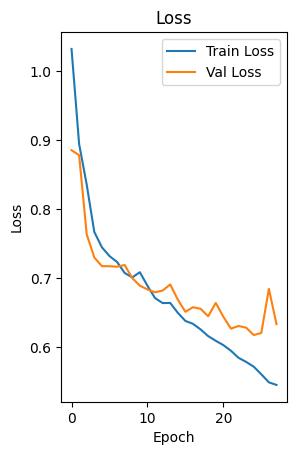

In [ ]:
# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

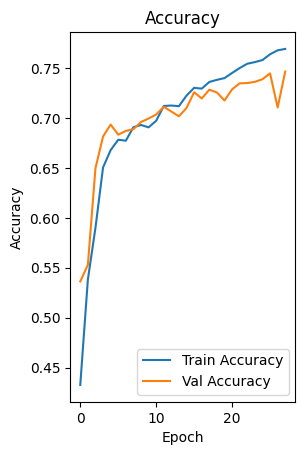

In [ ]:
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
text = "great flight amazing service"
text = "worst flight ever"
text = "I am going to my school"

new_tfidf = vectorizer.transform([text]).toarray()
new_tfidf_reshaped = new_tfidf.reshape(-1, max_features // seq_length, seq_length)
prediction = model.predict(new_tfidf_reshaped)
predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])[0]
print(f"\nExample Tweet: {text}")
print(f"Predicted Sentiment: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

Example Tweet: I am going to my school
Predicted Sentiment: negative
